In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import joblib


# Dataset Creation

In [3]:
center_location_map = {
    "UHC_1_KATHMANDU METROPOLITAN CITY": "Naxal", 
    "UHC_2_KATHMANDU METROPOLITAN CITY": "Lazimpat", 
    "UHC_3_KATHMANDU METROPOLITAN CITY": "Maharjgunj", 
    "UHC_4_KATHMANDU METROPOLITAN CITY": "Balwatar", 
    "UHC_5_KATHMANDU METROPOLITAN CITY": "Hadigaun", 
    "UHC_6_KATHMANDU METROPOLITAN CITY": "Baudhha", 
    "UHC_7_KATHMANDU METROPOLITAN CITY": "Mitrapark", 
    "UHC_8_KATHMANDU METROPOLITAN CITY": "Jai Bageshwori", 
    "UHC_9_KATHMANDU METROPOLITAN CITY": "Gaushala", 
    "UHC_10_KATHMANDU METROPOLITAN CITY": "Baneshwor", 
    "UHC_11_KATHMANDU METROPOLITAN CITY": "Babarmahal", 
    "UHC_12_KATHMANDU METROPOLITAN CITY": "Teku", 
    "UHC_13_KATHMANDU METROPOLITAN CITY": "Kalimati", 
    "UHC_14_KATHMANDU METROPOLITAN CITY": "Kalanki", 
    "UHC_15_KATHMANDU METROPOLITAN CITY": "Dallu", 
    "UHC_16_KATHMANDU METROPOLITAN CITY": "Balaju", 
    "UHC_17_KATHMANDU METROPOLITAN CITY": "Chhetrapati", 
    "UHC_18_KATHMANDU METROPOLITAN CITY": "Nardevi", 
    "UHC_19_KATHMANDU METROPOLITAN CITY": "Damai Tol", 
    "UHC_20_KATHMANDU METROPOLITAN CITY": "Bimsenthan", 
    "UHC_21_KATHMANDU METROPOLITAN CITY": "Jhwaa Bahal", 
    "UHC_22_KATHMANDU METROPOLITAN CITY": "Te Bahal", 
    "UHC_23_KATHMANDU METROPOLITAN CITY": "Om Bahal", 
    "UHC_24_KATHMANDU METROPOLITAN CITY": "Makhan", 
    "UHC_25_KATHMANDU METROPOLITAN CITY": "Masan Galli", 
    "UHC_26_KATHMANDU METROPOLITAN CITY": "Lainchaur", 
    "UHC_27_KATHMANDU METROPOLITAN CITY": "Maha Bahudha", 
    "UHC_28_KATHMANDU METROPOLITAN CITY": "Purano Buspark", 
    "UHC_29_KATHMANDU METROPOLITAN CITY": "Dilibazzar Pipalbot", 
    "UHC_30_KATHMANDU METROPOLITAN CITY": "Gyaneshwor", 
    "UHC_31_KATHMANDU METROPOLITAN CITY": "Shantinagar", 
    "UHC_32_KATHMANDU METROPOLITAN CITY": "Koteshwor"
}

vaccine_types = ["Pfizer-BioNTech", "Moderna", "AstraZeneca", "Johnson & Johnson", "Sinopharm"]

def random_date(start_date, end_date, used_dates):
    while True:
        delta = end_date - start_date
        random_days = random.randint(0, delta.days)
        random_date = start_date + timedelta(days=random_days)
        if random_date not in used_dates:
            used_dates.add(random_date)
            return random_date

start_date = datetime(2020, 10, 2)
end_date = datetime(2024, 3, 5)

vaccine_weights = [0.32, 0.05, 0.25, 0.05, 0.38]  
age_group_weights = [0.2, 0.3, 0.5]  
registration_freq = [52, 68, 89, 125, 250] 

data = []
used_dates_by_center = {center: set() for center in center_location_map.keys()}  

for _ in range(13526):
    center = random.choice(list(center_location_map.keys()))
    loc = center_location_map[center]  
    vaccine = random.choices(vaccine_types, vaccine_weights, k=1)[0]  
    registration_date_obj = random_date(start_date, end_date, used_dates_by_center[center])
    registration_date = registration_date_obj.strftime('%Y-%m-%d')
    
    total_registrations = random.randint(30, 500)  
    
    if total_registrations == 0:
        continue
    
    boys = random.randint(0, total_registrations)  
    girls = random.randint(0, total_registrations - boys)  
    formatted_center = center.replace("_", " ").title().replace("Metropolitan City", "Metropolitan City")
    
    data.append([formatted_center, loc, vaccine,registration_date,
                 total_registrations, boys, girls])
    
columns = [
    'vaccinationCenterName', 'location', 'vaccineName', 'vaccinationDate',
    'totalRegistrations', 'totalBoysRegistered', 'totalGirlsRegistered']

df = pd.DataFrame(data, columns=columns)

df.to_csv('/kaggle/working/vaccine_data.csv', index=False)
print(df.head())



                vaccinationCenterName        location      vaccineName  \
0  Uhc 28 Kathmandu Metropolitan City  Purano Buspark        Sinopharm   
1   Uhc 1 Kathmandu Metropolitan City           Naxal  Pfizer-BioNTech   
2   Uhc 8 Kathmandu Metropolitan City  Jai Bageshwori  Pfizer-BioNTech   
3  Uhc 10 Kathmandu Metropolitan City       Baneshwor        Sinopharm   
4  Uhc 27 Kathmandu Metropolitan City    Maha Bahudha  Pfizer-BioNTech   

  vaccinationDate  totalRegistrations  totalBoysRegistered  \
0      2022-06-06                 333                  202   
1      2022-08-23                 485                   28   
2      2023-12-22                  69                   28   
3      2022-12-25                  74                    5   
4      2022-05-03                 188                   37   

   totalGirlsRegistered  
0                    80  
1                   454  
2                    16  
3                    36  
4                    95  


# Exploratory data analysis(EDA)

In [4]:
df

,vaccinationCenterName,location,vaccineName,vaccinationDate,totalRegistrations,totalBoysRegistered,totalGirlsRegistered
0,Uhc 28 Kathmandu Metropolitan City,Purano Buspark,Sinopharm,2022-06-06,333,202,80
1,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2022-08-23,485,28,454
2,Uhc 8 Kathmandu Metropolitan City,Jai Bageshwori,Pfizer-BioNTech,2023-12-22,69,28,16
3,Uhc 10 Kathmandu Metropolitan City,Baneshwor,Sinopharm,2022-12-25,74,5,36
4,Uhc 27 Kathmandu Metropolitan City,Maha Bahudha,Pfizer-BioNTech,2022-05-03,188,37,95
...,...,...,...,...,...,...,...
13521,Uhc 6 Kathmandu Metropolitan City,Baudhha,AstraZeneca,2021-05-28,394,234,29
13522,Uhc 6 Kathmandu Metropolitan City,Baudhha,Sinopharm,2024-01-22,110,98,12
13523,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2023-07-23,294,123,156
13524,Uhc 11 Kathmandu Metropolitan City,Babarmahal,Sinopharm,2020-10-13,414,50,133


**Basic Data Exploration**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13526 entries, 0 to 13525
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   vaccinationCenterName  13526 non-null  object
 1   location               13526 non-null  object
 2   vaccineName            13526 non-null  object
 3   vaccinationDate        13526 non-null  object
 4   totalRegistrations     13526 non-null  int64 
 5   totalBoysRegistered    13526 non-null  int64 
 6   totalGirlsRegistered   13526 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 739.8+ KB


In [6]:
df.describe()


,totalRegistrations,totalBoysRegistered,totalGirlsRegistered
count,13526.000000,13526.000000,13526.000000
mean,265.984474,131.804525,67.014860
std,135.701812,108.684643,74.906427
min,30.000000,0.000000,0.000000
25%,148.000000,42.000000,12.000000
50%,267.000000,103.000000,40.000000
75%,384.000000,199.000000,95.000000
max,500.000000,491.000000,454.000000


In [7]:
df.isnull().sum()

vaccinationCenterName    0
location                 0
vaccineName              0
vaccinationDate          0
totalRegistrations       0
totalBoysRegistered      0
totalGirlsRegistered     0
dtype: int64

**Univariate Analysis**

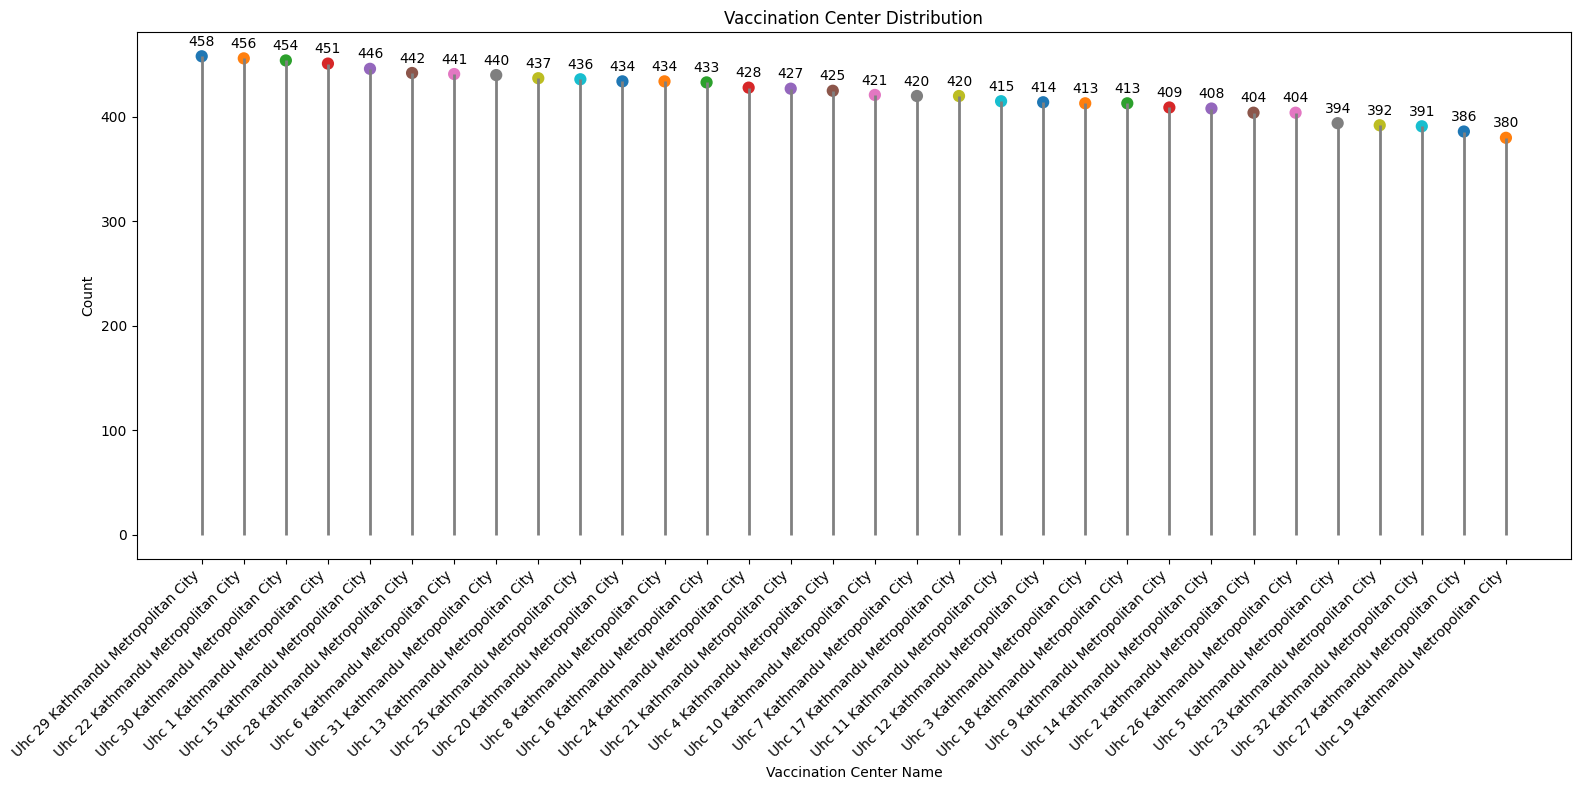

In [8]:
plt.figure(figsize=(16, 8))
sns.pointplot(x=df['vaccinationCenterName'].value_counts().index, 
              y=df['vaccinationCenterName'].value_counts().values, 
              color='b', 
              markers='o',
              linestyles='-',  
              palette='tab10') 

counts = df['vaccinationCenterName'].value_counts().values
centers = df['vaccinationCenterName'].value_counts().index

for i, count in enumerate(counts):
    plt.vlines(x=i, ymin=0, ymax=count, color='grey', linestyles='-', linewidth=2)  
    plt.text(i, count + 7, str(count), ha='center', va='bottom', fontsize=10, color='black')  

plt.xticks(rotation=45, ha='right')  
plt.xlabel('Vaccination Center Name')
plt.ylabel('Count')
plt.title('Vaccination Center Distribution')

# Show plot
plt.tight_layout()
plt.show()


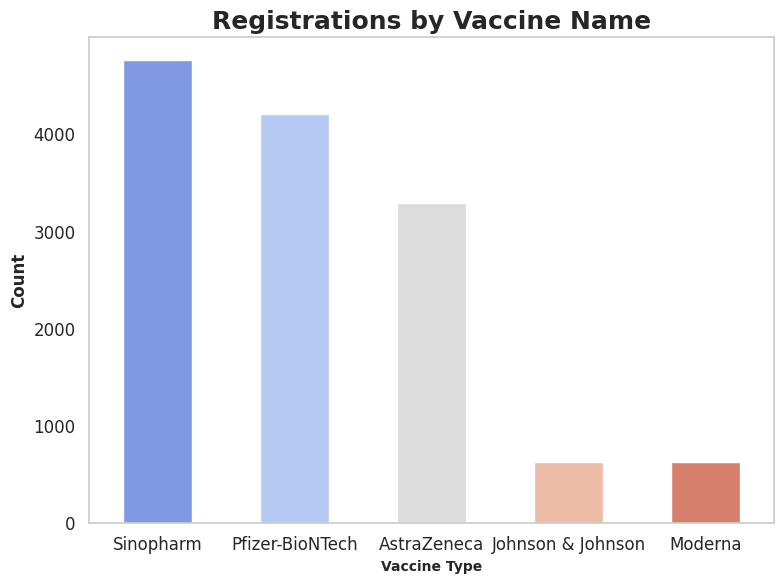

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="coolwarm")

plt.figure(figsize=(8, 6))

ax = sns.countplot(data=df, x='vaccineName', order=df['vaccineName'].value_counts().index, palette='coolwarm', width=0.5)

plt.title('Registrations by Vaccine Name', fontsize=18, weight='bold')
plt.xlabel('Vaccine Type', fontsize=10, weight='bold')
plt.ylabel('Count', fontsize=12, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-10-c54915b546c8>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


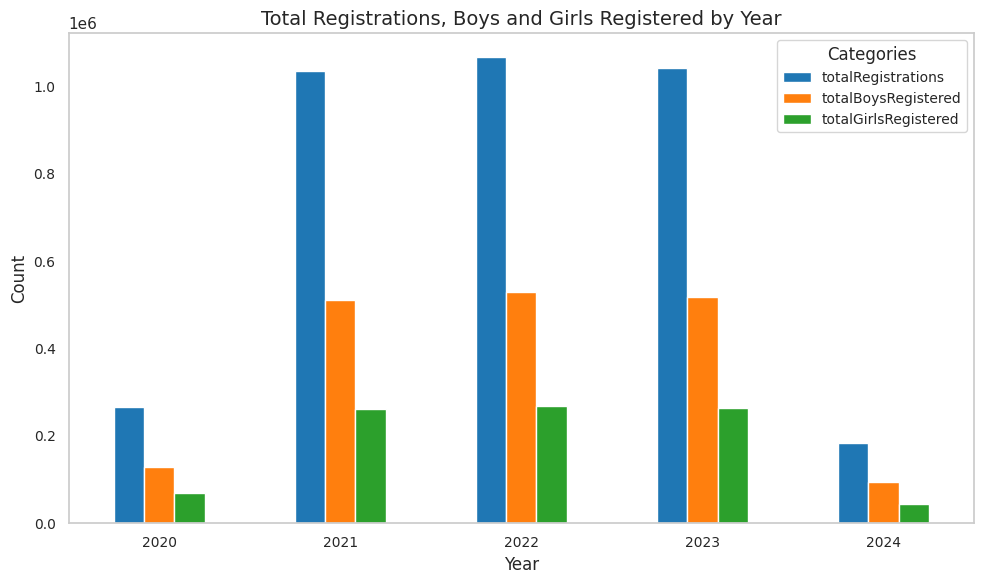

In [10]:
df['vaccinationDate'] = pd.to_datetime(df['vaccinationDate'])
df['year'] = df['vaccinationDate'].dt.year

yearly_data = df.groupby('year')[['totalRegistrations', 'totalBoysRegistered', 'totalGirlsRegistered']].sum()

bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.style.use('seaborn-muted')

ax = yearly_data.plot(kind='bar', figsize=(10, 6), color=bar_colors)

plt.title('Total Registrations, Boys and Girls Registered by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

plt.legend(title='Categories', fontsize=10, title_fontsize=12)

ax.grid(False)

plt.tight_layout()

plt.show()

# Feature Engineering

In [11]:



def get_weather_condition(date): 
    if date.month == 1 or date.month == 2:
        return 'Cold'
    elif date.month == 3 or date.month == 4:
        return 'Sunny'
    elif date.month == 5 or date.month == 6:
        return 'Humid'
    elif date.month == 7 or date.month == 8:
        return 'Rainy'
    elif date.month == 9 or date.month == 10:
        return 'Dry'
    elif date.month == 11 or date.month == 12:
        return 'Mild Cold'
df['weatherCondition'] = df['vaccinationDate'].apply(get_weather_condition)





In [12]:
df

,vaccinationCenterName,location,vaccineName,vaccinationDate,totalRegistrations,totalBoysRegistered,totalGirlsRegistered,year,weatherCondition
0,Uhc 28 Kathmandu Metropolitan City,Purano Buspark,Sinopharm,2022-06-06,333,202,80,2022,Humid
1,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2022-08-23,485,28,454,2022,Rainy
2,Uhc 8 Kathmandu Metropolitan City,Jai Bageshwori,Pfizer-BioNTech,2023-12-22,69,28,16,2023,Mild Cold
3,Uhc 10 Kathmandu Metropolitan City,Baneshwor,Sinopharm,2022-12-25,74,5,36,2022,Mild Cold
4,Uhc 27 Kathmandu Metropolitan City,Maha Bahudha,Pfizer-BioNTech,2022-05-03,188,37,95,2022,Humid
...,...,...,...,...,...,...,...,...,...
13521,Uhc 6 Kathmandu Metropolitan City,Baudhha,AstraZeneca,2021-05-28,394,234,29,2021,Humid
13522,Uhc 6 Kathmandu Metropolitan City,Baudhha,Sinopharm,2024-01-22,110,98,12,2024,Cold
13523,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2023-07-23,294,123,156,2023,Rainy
13524,Uhc 11 Kathmandu Metropolitan City,Babarmahal,Sinopharm,2020-10-13,414,50,133,2020,Dry


# Pre-processing and Model Traning

In [13]:


def preprocess_data(df):
    df['biasRatio'] = df['totalBoysRegistered'] / df['totalGirlsRegistered']
    
    def bias_type(row):
        male_percentage = row['totalBoysRegistered'] / (row['totalBoysRegistered'] + row['totalGirlsRegistered']) * 100
        female_percentage = row['totalGirlsRegistered'] / (row['totalBoysRegistered'] + row['totalGirlsRegistered']) * 100
        
        if male_percentage > 61:
            return 'Male biased'
        elif female_percentage > 61:
            return 'Female biased'
        elif 39 <= male_percentage <= 61 and 39 <= female_percentage <= 61:
            return 'Neutral'
        else:
            return 'Neutral'
    
    df['biasTypeLabel'] = df.apply(bias_type, axis=1)
    return df


df = preprocess_data(df)
df = df[(df['biasRatio'].notnull()) & (~df['biasRatio'].isin([np.inf, -np.inf]))]


X = df[['totalRegistrations', 'totalBoysRegistered', 'totalGirlsRegistered']]
y = df['biasRatio']

numeric_features = ['totalRegistrations', 'totalBoysRegistered', 'totalGirlsRegistered']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

params = {
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
}

models = [
    ('LGBM', LGBMRegressor(device='gpu', **params), {})
]

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    results[name] = {'Mean MSE': np.mean(mse_scores)}
    print("Mean Squared Error (MSE) scores for each fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"Fold {i}: {mse:.4f}")

print(f"Mean MSE across folds: {np.mean(mse_scores):.4f}")





[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 10468, number of used features: 3
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 3 dense feature groups (0.04 MB) transferred to GPU in 0.001981 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 12.331518
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 10469, number of used features: 3
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 3 dense feature groups

# Pickling The Model

In [14]:
df

,vaccinationCenterName,location,vaccineName,vaccinationDate,totalRegistrations,totalBoysRegistered,totalGirlsRegistered,year,weatherCondition,biasRatio,biasTypeLabel
0,Uhc 28 Kathmandu Metropolitan City,Purano Buspark,Sinopharm,2022-06-06,333,202,80,2022,Humid,2.525000,Male biased
1,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2022-08-23,485,28,454,2022,Rainy,0.061674,Female biased
2,Uhc 8 Kathmandu Metropolitan City,Jai Bageshwori,Pfizer-BioNTech,2023-12-22,69,28,16,2023,Mild Cold,1.750000,Male biased
3,Uhc 10 Kathmandu Metropolitan City,Baneshwor,Sinopharm,2022-12-25,74,5,36,2022,Mild Cold,0.138889,Female biased
4,Uhc 27 Kathmandu Metropolitan City,Maha Bahudha,Pfizer-BioNTech,2022-05-03,188,37,95,2022,Humid,0.389474,Female biased
...,...,...,...,...,...,...,...,...,...,...,...
13521,Uhc 6 Kathmandu Metropolitan City,Baudhha,AstraZeneca,2021-05-28,394,234,29,2021,Humid,8.068966,Male biased
13522,Uhc 6 Kathmandu Metropolitan City,Baudhha,Sinopharm,2024-01-22,110,98,12,2024,Cold,8.166667,Male biased
13523,Uhc 1 Kathmandu Metropolitan City,Naxal,Pfizer-BioNTech,2023-07-23,294,123,156,2023,Rainy,0.788462,Neutral
13524,Uhc 11 Kathmandu Metropolitan City,Babarmahal,Sinopharm,2020-10-13,414,50,133,2020,Dry,0.375940,Female biased


In [15]:
y_pred

array([0.23999534, 0.52913202, 1.23710672, ..., 7.28798516, 1.99064259,
       1.29040892])

In [16]:
filename = 'lgbm_pipeline.pkl'
joblib.dump(pipeline, filename)

print(f"Pipeline saved as {filename}")

Pipeline saved as lgbm_pipeline.pkl
